<a href="https://colab.research.google.com/github/Approach-Analytics/Emotion-Classifier/blob/main/Train_Despair_RNN_April12%2C2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Despair: Refactored training run - April 12,2023

Synchronize this notebook with the new dataset creation capacity. 

In [1]:
#Need pip install tensorflow with...Jupyter Notebook

!pip install nlp
#!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd


In [3]:
#Dec 7, 2022: Not sure what this piece of code is used for... 

import warnings
warnings.filterwarnings('ignore')

In [4]:
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 100)


##Importing dataset and despair_axis definition 

In [5]:
#Defining the despair axis
#Removed: April 12, 2023: "content"

despair_axis = {
    "accepting": ["calm", "calming", "peaceful", "serene", "serenity", "untroubled", "contented", "composed", "tranquil"],
    "demoralized": ["demoralized", "demoralizing", "demoralization", "dispirited", "dispiriting", "disheartened", "disheartening", "discouraged", "discouraging", "deflated","despondent", "despondency", "downhearted", "gloomy", "gloomily", "pessimistic", "pessimistically", "morose", "morosely", "disconsolate"],
    "hopelessness": ["hopeless", "hopelessness", "forlorn", "forlornly", "desolate", "desolately", "disheartened", "discouraged"],
    "alone": ["lonely","alone","forsaken","abandoned","isolated"], 
    "depression": ["depressed", "depression","depressing","downtrodden", "downtroddenly","dejected","dour"],
    "despair": ["despair", "desperate", "desperation", "anguish", "anguished", "misery", "miserable","miserably","distress", "distressed", "torment", "tormented"]
}


In [6]:
# Load the Drive helper and mount

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Load the dataset 

path = path = "/content/drive/MyDrive/Sean/Emoclass/Emotion datasets/Despair_G2000_166K_April12,2023.csv"
df = pd.read_csv(path)

In [8]:
df. head()

,text,emotion1,emotion2,word_count,Emotion_Word_Count
0,down when the smoke cleared away i was occupyi...,alone,alone,83,1
1,some remarks about taking it out of my hide an...,alone,alone,81,1
2,seems to be some kind of a wedding march and a...,desperate,despair,79,1
3,i would trail to hear the cracks it was grand ...,miserable,despair,88,1
4,smile upon his face there are faces his was su...,calm,accepting,81,1


In [9]:
df.columns

Index(['text', 'emotion1', 'emotion2', 'word_count', 'Emotion_Word_Count'], dtype='object')

In [10]:
#df['Emotion_Word_Count'].value_counts().sort_index()

In [11]:
#Relabelling a column... if needed... 

df.rename(columns={"emotion2": "label"},inplace =True)

In [12]:
#Let's see if we have missing values...No missing values... 

df.isna().sum()

text                  0
emotion1              0
label                 0
word_count            0
Emotion_Word_Count    0
dtype: int64

#Truncating Word Length 

In [53]:
#Defining function to calculate word length

def count_words(text):
    return len(text.split())

df['word_count'] = df['text'].apply(count_words)

In [54]:
df['word_count'].describe()

count    170470.000000
mean         75.239602
std           5.573650
min          37.000000
25%          72.000000
50%          75.000000
75%          79.000000
max         118.000000
Name: word_count, dtype: float64

In [49]:
def truncate_text(text, max_len, keyword):
    if len(text) <= max_len:
        return text
    
    # Find the index of the keyword in the text
    keyword_idx = text.find(keyword)
    
    # If the keyword is not found or is too close to the ends of the text, just truncate from the ends
    if keyword_idx == -1 or keyword_idx < max_len//2 or keyword_idx > len(text) - max_len//2:
        return text[:max_len]
    
    # Truncate from both sides
    start_idx = keyword_idx - max_len//2
    end_idx = keyword_idx + max_len//2
    return text[start_idx:end_idx]


In [55]:
# Apply the function to the 'text' column and create a new column 'truncated_text'
df['truncated_text'] = df.apply(lambda row: truncate_text(row['text'], max_len=100, keyword='emotion1'), axis=1)

In [57]:
#Redoing the word count....I think this needs to get reapplied... 


df["word_count_trunc"] = df['truncated_text'].apply(count_words)

In [59]:
#Checking word length again... 

df['word_count_trunc'].describe()

count    170470.000000
mean         19.328462
std           2.034797
min           8.000000
25%          18.000000
50%          19.000000
75%          21.000000
max          35.000000
Name: word_count_trunc, dtype: float64

##Replacing the emotion words in the dataset 

In [17]:
#Generate all the unique emotion words that then get replaced... 

a = df['emotion1'].unique().tolist()

#The list a is our list of variable responses from the dataset... 
keyword = "emotion word"
words = a
for j in words: 
  df['text'] = df['text'].str.replace(j,keyword)

##Counting vocab size 

In [18]:
#Total vocabulary size prior to truncation 

from tensorflow.keras.preprocessing.text import Tokenizer

# convert the text into a list
text = df['text'].tolist()

# create a Tokenizer object
tokenizer = Tokenizer()

# fit the tokenizer on the text data
tokenizer.fit_on_texts(text)

# calculate the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

114559

##Splitting into train, validate and test datasets 

In [20]:
#This seems to be hte simplest way to do the 3 way training split...
#And then this outputs 3 different dataframes... originally 0.6 and 0.8

train, validate, test = np.split(df.sample(frac=1, random_state=42),
                       [int(.8*len(df)), int(.9*len(df))])

##Preparing Labels - Needs manual label

In [21]:
#Converting the pandas dataframe into a list of labels... 
#We may consider puting this into a function... 

trainlabel=train['label'].tolist()
vallabel=validate['label'].tolist()
testlabel=test['label'].tolist()

In [22]:
#Creating the classes variable... 

classes = list(despair_axis.keys())


In [23]:
# Map each class to a unique integer
classes_to_index = dict((c, i) for i, c in enumerate(classes))

# Map each integer back to its corresponding class
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [24]:
#Creating a lambda function...called "names_to_ids"

names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [25]:
#Applying the names_to_ids functions to the labels

train_labels = names_to_ids(trainlabel)
val_labels = names_to_ids(vallabel)
test_labels = names_to_ids(testlabel)

#Testing out the labels...
print(train_labels[10])

3


##Input Training Text and Tokenizing Tweets

In [26]:
#Converting the different pandas dataframes into a list of text fields...
#Choice of variables: truncated_text, text_minus1, 'filtered_text',''filtered_text_minus1'

traintext=train['text'].tolist()
valtext=validate['text'].tolist()
testtext=test['text'].tolist()

In [27]:
#Importing the tokenizer...
#Input into the tokenizer is a list

from tensorflow.keras.preprocessing.text import Tokenizer

In [28]:
#Input into the tokenizer is a list

tokenizer = Tokenizer(num_words=113488, oov_token='<UNK>')

#I think that this is the missing piece...I'm not really sure what it does...  

tokenizer.fit_on_texts(traintext)
#tokenizer.fit_on_texts(valtext)

#Testing the tokenization... 

#print(tokenizer.texts_to_sequences([tweets[10]]))

#Padding and Truncating Sequences 

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
#Creating a function that tokenizes and pads the sequences...

def get_sequences(tokenizer, texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=300, padding='post')
    return padded_sequences

In [31]:
#Applying the function to tokenize and pad... to all test,validate and test
#Syntax: val_sequences = get_sequences(tokenizer, val_tweets)

padded_train_sequences = get_sequences(tokenizer, traintext)
val_sequence = get_sequences(tokenizer,valtext)
test_sequence = get_sequences(tokenizer,testtext)


##Creating and training the model 

In [32]:
#Embedding layer works on number of tokens -> approximately words... 
#Adding another layer: tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(500, return_sequences=True)),

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(113488, 300, input_length=300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          34046400  
                                                                 
 bidirectional (Bidirectiona  (None, 300, 600)         1442400   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 600)              2162400   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 3606      
                                                                 
Total params: 37,654,806
Trainable params: 37,654,806
Non-trainable params: 0
_________________________________________________________________


In [33]:
#Having the callbacks option on means that the model stops once you are like over-generalizing... 
#Let's leave the callback option on for now...


h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
   ]
)

Epoch 1/3
4262/4262 [==============================] - 552s 126ms/step - loss: 1.4474 - accuracy: 0.3817 - val_loss: 1.2611 - val_accuracy: 0.5295
Epoch 2/3
4262/4262 [==============================] - 529s 124ms/step - loss: 0.9809 - accuracy: 0.6662 - val_loss: 0.9156 - val_accuracy: 0.6890
Epoch 3/3
4262/4262 [==============================] - 531s 125ms/step - loss: 0.7115 - accuracy: 0.7588 - val_loss: 0.8919 - val_accuracy: 0.7059


In [66]:
from sklearn.utils import class_weight

# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels)

# Train the model with class weights
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequence, val_labels),
    epochs=3,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)


TypeError: ignored

#Evaluating The Model 

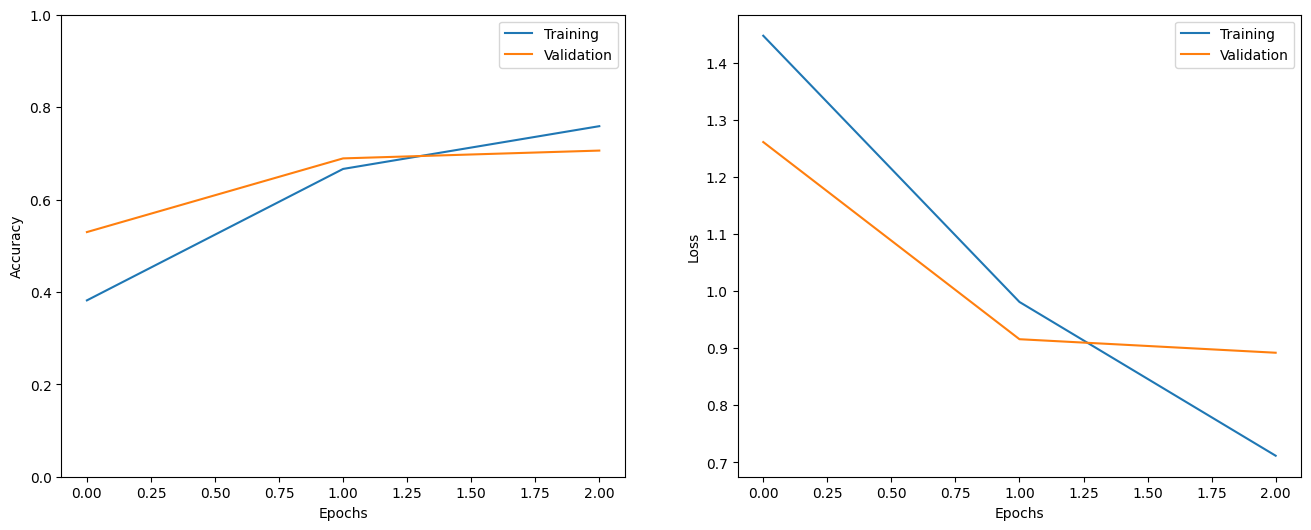

In [45]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(h)

In [35]:
#Running the model on the test sequence and test labels... 

eval = model.evaluate(test_sequence, test_labels)

533/533 [==============================] - 22s 41ms/step - loss: 0.8795 - accuracy: 0.7099


In [36]:
#preds = model.predict_classes(test_sequence)
preds=model.predict(test_sequence) 
classes_x=np.argmax(preds,axis=1)
preds.shape, test_labels.shape

533/533 [==============================] - 23s 41ms/step


((17047, 6), (17047,))

##Error Analysis 

In [60]:
#Dumb luck metric 

counts = df['label'].value_counts()
dumb_luck = max(counts) / sum(counts)

dumb_luck


0.3211356836980114

In [61]:
#Creating an inference dataframe 

inf_df=pd.DataFrame({
    'data':testtext,
    "labels_predicted": classes_x                    
})
inf_df["labels_predicted_marked"]=inf_df['labels_predicted'].apply(lambda x: index_to_classes[x])
inf_df["actual_labels"]=testlabel

#Creating the labels index datastructure...

inf_df["actual_label_index"]=inf_df['actual_labels'].apply(lambda x: classes_to_index[x])



In [62]:
#Checking the inf_df shape...

inf_df.shape

(17047, 5)

In [63]:
#Making the correct prediction 

inf_df['correct_pred']=0 # first assigning all to 0.
inf_df.loc[(inf_df['labels_predicted']==inf_df['actual_label_index']),'correct_pred']=1 # labelling 1 if the prediction is right.

In [64]:
# magnitutde of error
inf_df['error_magnitude']=abs(inf_df['labels_predicted']-inf_df['actual_label_index'])

Text(0, 0.5, 'Frequency')

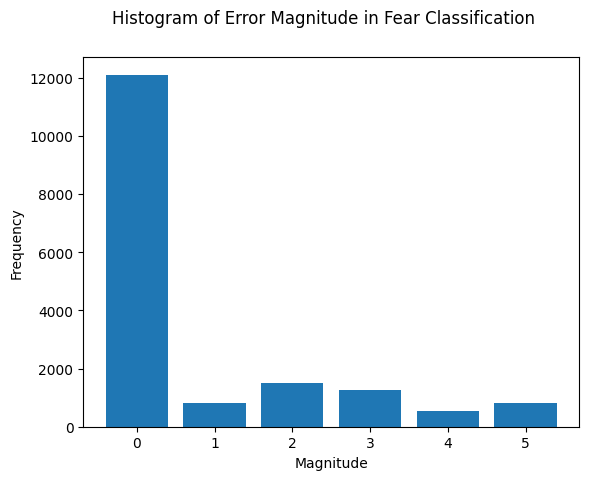

In [65]:
# Count the frequency of each class in the error_magnitude column
counts = inf_df['error_magnitude'].value_counts()

# Create a histogram with one bar for each class
plt.bar(counts.index, counts.values)

# Set the title and axis labels
plt.suptitle('Histogram of Error Magnitude in Fear Classification')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')

##Saving the model and evaluation dataset

In [42]:
#So this works but we need to make sure that we install Keras as a dependency 

from keras.models import load_model

#model.save('/content/drive/MyDrive/Sean/Emoclass_Dec2022/Model_Fear_151K_Feb23,2022')

In [43]:
#Exporting the evaluation dataset 

In [44]:
#Exporting the dataset 

#path = "/content/drive/MyDrive/Sean/Emoclass/Train_Fear_Error_Analysis_151K_March8,2023.csv"
inf_df.to_csv(path)
